For this version, I took my existing model and tried to add a grid search function at the end, similar to how we've used GridSearchCV, based on his code. (So basically, I tried to write my own grid search loop.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dataset_train = pd.read_csv('MSFT 5-15 to 5-19.csv')
print(dataset_train.head())
print(dataset_train.info())
print(dataset_train.isna().sum())
training_set = dataset_train.iloc[:, 1:2].values

         Date       Open       High        Low      Close  Adj Close    Volume
0  2015-05-04  48.369999  48.869999  48.180000  48.240002  43.497272  34039500
1  2015-05-05  47.820000  48.160000  47.310001  47.599998  42.920189  50369200
2  2015-05-06  47.570000  47.770000  46.020000  46.279999  41.729969  52433000
3  2015-05-07  46.270000  47.090000  46.160000  46.700001  42.108677  32971700
4  2015-05-08  47.549999  47.980000  47.520000  47.750000  43.055447  35364900
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 7 columns):
Date         1007 non-null object
Open         1007 non-null float64
High         1007 non-null float64
Low          1007 non-null float64
Close        1007 non-null float64
Adj Close    1007 non-null float64
Volume       1007 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 55.2+ KB
None
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype

In [3]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [4]:
X_train = []
y_train = []
for i in range(60, 1007):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [6]:
regressor = Sequential()

regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 100))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
947/947 [==============================] - 13s 14ms/step - loss: 0.0230
Epoch 2/100
947/947 [==============================] - 10s 10ms/step - loss: 0.0029
Epoch 3/100
947/947 [==============================] - 10s 10ms/step - loss: 0.0027
Epoch 4/100
947/947 [==============================] - 10s 11ms/step - loss: 0.0025
Epoch 5/100
947/947 [==============================] - 10s 10ms/step - loss: 0.0023
Epoch 6/100
947/947 [==============================] - 11s 12ms/step - loss: 0.0027
Epoch 7/100
947/947 [==============================] - 10s 10ms/step - loss: 0.0021
Epoch 8/100
947/947 [==============================] - 10s 10ms/step - loss: 0.0019
Epoch 9/100
947/947 [==============================] - 10s 10ms/step - loss: 0.0021
Epoch 10/100
947/947 [==============================] - 10s 11ms/step - loss: 0.0024
Epoch 11/100
947/947 [==============================] - 10s 10ms/step - loss: 0.0023
Epoch 12/100
947/947 [==============================] - 10s 10ms/step - lo

947/947 [==============================] - 10s 10ms/step - loss: 0.0010
Epoch 98/100
947/947 [==============================] - 10s 10ms/step - loss: 8.9944e-04
Epoch 99/100
947/947 [==============================] - 9s 10ms/step - loss: 0.0011
Epoch 100/100
947/947 [==============================] - 9s 10ms/step - loss: 9.8517e-04


In [7]:
print(regressor.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 100)           80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)              

In [8]:
dataset_test = pd.read_csv('MSFT.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [9]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [10]:
X_test = []
for i in range(60, 312):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [11]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(real_stock_price, predicted_stock_price)
rmse = np.sqrt(mse)
print('MSE: %.2f'% mse)
print('RMSE: %.2f'% rmse)

MSE: 32.92
RMSE: 5.74


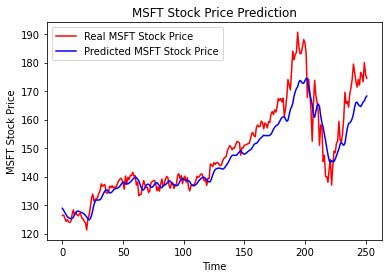

In [12]:
plt.plot(real_stock_price, color = 'red', label = 'Real MSFT Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted MSFT Stock Price')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MSFT Stock Price')
plt.legend()
plt.show()

In [13]:
#n_nodes = [100, 200] I commented this out to see if it ran better just using 100 nodes; it just gives different errors though.
n_epochs = [50, 100]
n_batch = [32, 64]

In [14]:
def model_fit(X_train, y_train):
    model = Sequential()
    model.add(LSTM(units = 100, return_sequences = True, input_shape=(X_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 100, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 100, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 100))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    model.compile(loss='mse', optimizer='adam')
    
    model.fit(X_train, y_train, epochs = n_epochs, batch_size = n_batch)
    return model

In [15]:
def grid_search(X_train, y_train):
    predicted_stock_price = regressor.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    rmse_list = list()
    for i in n_epochs:
        for j in n_batch:
            model_fit(X_train, y_train)
            rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
            rmse_list.append([i,j,rmse])
    return rmse_list

In [16]:
grid_search(X_train, y_train)

TypeError: 'list' object cannot be interpreted as an integer